In [1]:
import sys
sys.path.append("../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    NBEATSModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt

import ray
from ray import tune
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"
ray.init(num_gpus=1)



{'node_ip_address': '130.149.248.55',
 'raylet_ip_address': '130.149.248.55',
 'redis_address': '130.149.248.55:24353',
 'object_store_address': '/tmp/ray/session_2022-03-12_10-50-26_170141_252678/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-12_10-50-26_170141_252678/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-12_10-50-26_170141_252678',
 'metrics_export_port': 63405,
 'gcs_address': '130.149.248.55:43157',
 'node_id': '57cd838c549ba460de4142826bc1754a8f2b612a73125994b19b0922'}

Text(0.5, 1.0, 'Augmented whole train multiple times')

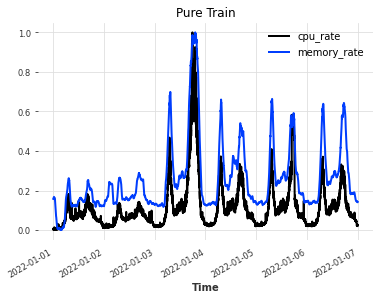

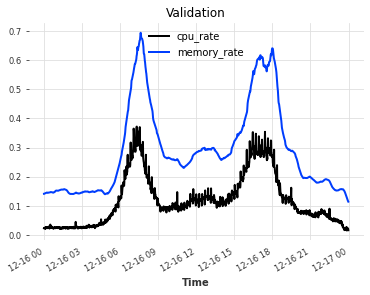

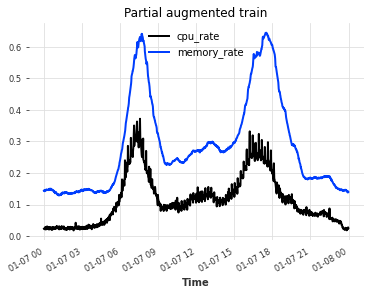

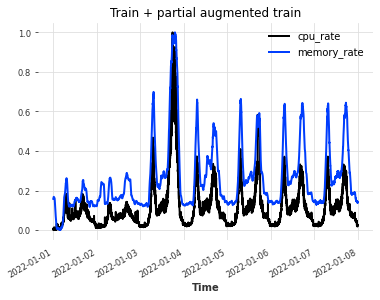

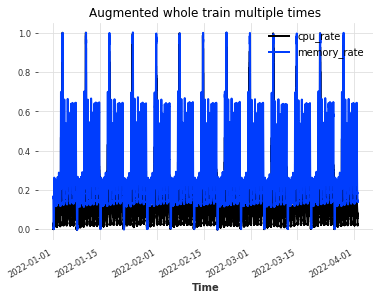

In [8]:
import matplotlib.pyplot as plt

dl =  DatasetLoader( 'data/cpu_memory_rate.csv', "Time", ["cpu_rate","memory_rate"],
                    resample_freq="1min", augment=False, shift_df_datetime="2022-01-01 00:00:00")
train, val, _ = dl.get_train_val_test(train_size=6/7,val_test_ratio=1.0)
train.plot()
plt.title("Pure Train")
val = dl.shift_series_to(val, "2022-12-16 00:00:00")

val.plot(new_plot=True)
plt.title("Validation")

#it slices the train data from 2022-01-06 00:00:00 till end of the train data which 2022-01-07 00:00:00
#and augment one day based on this sliced date and finally append it to the train data
partial_augmented_series = (dl.augment_specific_times(train, [slice("2022-01-06 00:00:00", None)]))
partial_augmented_series.plot(new_plot=True)
plt.title("Partial augmented train")
train = train.append(partial_augmented_series)
train.plot(new_plot=True)
plt.title("Train + partial augmented train")
train = dl.augment_series(train)
train.plot(new_plot=True)
plt.title("Augmented whole train multiple times")

In [ ]:
quantiles = [0.1, 0.5, 0.9]
input_chunk_length = 30
output_chunk_length = 15
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    num_stacks=50,
    num_blocks=1,
    num_layers=8,
    layer_widths=256,
    batch_size=64,
    n_epochs=21, 
    random_state=0,
    log_tensorboard=True,
    add_encoders={
    'datetime_attribute': {'past': ['dayofweek']},
    'custom': {'past': [lambda idx: (idx.minute) + (idx.hour*60)]},
    "position": {"past": ["relative"]},
    'transformer': Scaler()
    },
    likelihood=QuantileRegression(
        quantiles=quantiles
    ), 
    work_dir="logs/nbeats_no_hparam",
    torch_device_str='cuda:0'
)

model.fit(train, val_series=val, verbose=True)

[2022-03-12 10:59:58,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 130996 samples.
[2022-03-12 10:59:58,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 130996 samples.
[2022-03-12 10:59:58,990] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 10:59:58,990] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/21 [00:00<?, ?it/s]

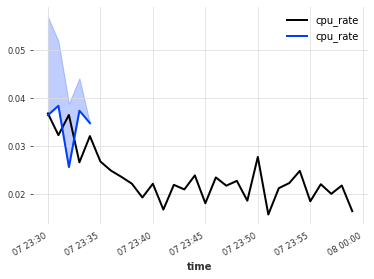

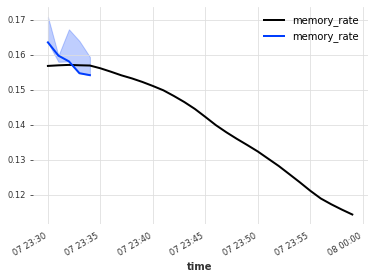

In [27]:
pred_len = 30
pred = model.predict(series=val[:-pred_len], n=5, num_samples=500)
for i in range(pred.n_components):
    val[-pred_len:].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9)
    plt.show()

In [ ]:
# pred = model.predict(n=input_chunk_length, num_samples=500)
# rr = 0.0
# for rho in quantiles:
#     rr += rho_risk(val[:input_chunk_length], pred, rho=rho)
# rr = rr / len(quantiles)